In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
import time

from sklearn.preprocessing import MinMaxScaler

!pip install neurodsp
!pip install seaborn

import seaborn as sns

# Import function for Morlet Wavelets
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.plts import plot_time_series, plot_timefrequency

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 3.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Get the current working directory (where your notebook is)
current_directory = os.getcwd()

# Construct the full path to your data_utils.py file
data_utils_path = '/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Thesis Files/data_utils.py'  # Replace with the actual path

# Add the directory containing data_utils.py to the Python path
sys.path.append(os.path.dirname(data_utils_path))  # Add parent directory of data_utils.py


# Now you can import the custom module
import data_utils as du

sys.path = []

In [ ]:
# ONLY FOR RELOAD!

# Reloads if the data_utils has been updated during runtime
# Always need to add and reset the paths
import importlib

# Add the directory containing data_utils.py to the Python path
sys.path.append(os.path.dirname(data_utils_path))  # Add parent directory of data_utils.py

importlib.reload(du)  # This reloads the module

sys.path = []

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Including Features/5_class_mid_noise_30s_features_vec.npy"
label_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Including Features/5_class_mid_noise_30s_numeric_label_vec.npy"

data_vec, label_vec = du.load_data(data_path, label_path)

du.data_info(data_vec)

DATASET INFO:
Shape: (10, 20, 5, 7500, 25)

No of Samples: 10

No of Frequencies: 20
Freqency values: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(11), np.int64(13), np.int64(16), np.int64(18), np.int64(22), np.int64(26), np.int64(31), np.int64(36), np.int64(43), np.int64(51), np.int64(60), np.int64(71), np.int64(84), np.int64(100)]

No of noise ratios: 5
Signal to Noise ratios (in db) [np.int64(-10), np.int64(-8), np.int64(-6), np.int64(-4), np.int64(-2), np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8)]

No of Datapoints: 7500

No of Features per Datapoint: 25 (signal, hilbert amp, 20 wavelets for each freq)


In [ ]:
label_binary = label_vec.copy()
label_binary[label_binary >= 1] = 1  # Convert to binary labels

In [ ]:
print(label_vec[0,8,3,:70])
print(label_binary[0,8,3,:70])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [ ]:
mean_freqs = np.logspace(np.log10(4), np.log10(100), num=20)
mean_freqs_round = np.round(mean_freqs).astype(int)

mean_freqs_manual = [4, 5, 5.5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 22, 26, 30, 45, 60, 80, 100]

snr_range = np.arange(-10, 10, 2)

print(snr_range)
print(mean_freqs_round)
print(mean_freqs_manual)

[-10  -8  -6  -4  -2   0   2   4   6   8]
[  4   5   6   7   8   9  11  13  16  18  22  26  31  36  43  51  60  71
  84 100]
[4, 5, 5.5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 22, 26, 30, 45, 60, 80, 100]


In [ ]:
## Class distribution
unique, counts = np.unique(label_vec.flatten(), return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")
print(f"Noise  Percentage: {(counts[0]/(sum(counts))):.4f}")
print(f"Theta Percentage: {(counts[1]/(sum(counts))):.4f}")
print(f"Alpha Percentage: {(counts[2]/(sum(counts))):.4f}")
print(f"Beta Percentage: {(counts[3]/(sum(counts))):.4f}")
print(f"Gamma Percentage: {(counts[4]/(sum(counts))):.4f}")

Class distribution: {np.int64(0): np.int64(4008043), np.int64(1): np.int64(882021), np.int64(2): np.int64(882177), np.int64(3): np.int64(886981), np.int64(4): np.int64(840778)}
Noise  Percentage: 0.5344
Theta Percentage: 0.1176
Alpha Percentage: 0.1176
Beta Percentage: 0.1183
Gamma Percentage: 0.1121


In [ ]:
## Binary Class distribution
unique, counts = np.unique(label_binary.flatten(), return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")
print(f"Noise  Percentage: {(counts[0]/(sum(counts))):.4f}")
print(f"Burst Percentage: {(counts[1]/(sum(counts))):.4f}")

Class distribution: {np.int64(0): np.int64(4008043), np.int64(1): np.int64(3491957)}
Noise  Percentage: 0.5344
Burst Percentage: 0.4656


## Feature Correlation Metrics

1. Binary Correlations
2. Multi Correlations (One-Hot Encode Labels)



In [ ]:
feature_vec = data_vec[0].reshape(-1, data_vec.shape[-1])
label_sample_vec = label_vec[0].flatten()

label_sample_vec = du.one_hot_encode_single_sample(label_sample_vec, categories=[0,1,2,3,4])

In [ ]:
print(feature_vec.shape)
print(label_sample_vec.shape)

(750000, 25)
(750000, 5)


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def feature_category_correlation(feature_data, label_data, category_names):
    """
    Calculates the correlation between features and categories and displays it in a table.

    Args:
        feature_data (np.ndarray): Feature data of shape (N, F) where N is the number of samples and F is the number of features.
        label_data (np.ndarray): Label data of shape (N, 5) where 5 represents the 5 categories.
        category_names (list): List of category names (e.g., ['Noise', 'Theta', 'Alpha', 'Beta', 'Gamma']).

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the correlation matrix.
    """
    # Reshape label_data to 2D if it has more than 2 dimensions
    label_data = label_data.reshape(-1, label_data.shape[-1])
    # Reshape feature_data to 2D to match label_data
    feature_data = feature_data.reshape(-1, feature_data.shape[-1])

    num_features = feature_data.shape[1]
    num_categories = label_data.shape[1]

    correlation_matrix = np.zeros((num_features, num_categories))

    for feature_idx in range(num_features):
        for category_idx in range(num_categories):
            correlation_matrix[feature_idx, category_idx] = np.corrcoef(
                feature_data[:, feature_idx], label_data[:, category_idx]
            )[0, 1]  # Get the correlation coefficient

    # Create a Pandas DataFrame for the table
    correlation_df = pd.DataFrame(correlation_matrix,
                                  index=[f"Feature {i}" for i in range(num_features)],
                                  columns=category_names)

    return correlation_df

# Example usage:
category_names = ['Noise', 'Theta', 'Alpha', 'Beta', 'Gamma']
correlation_table = feature_category_correlation(feature_vec, label_sample_vec, category_names)

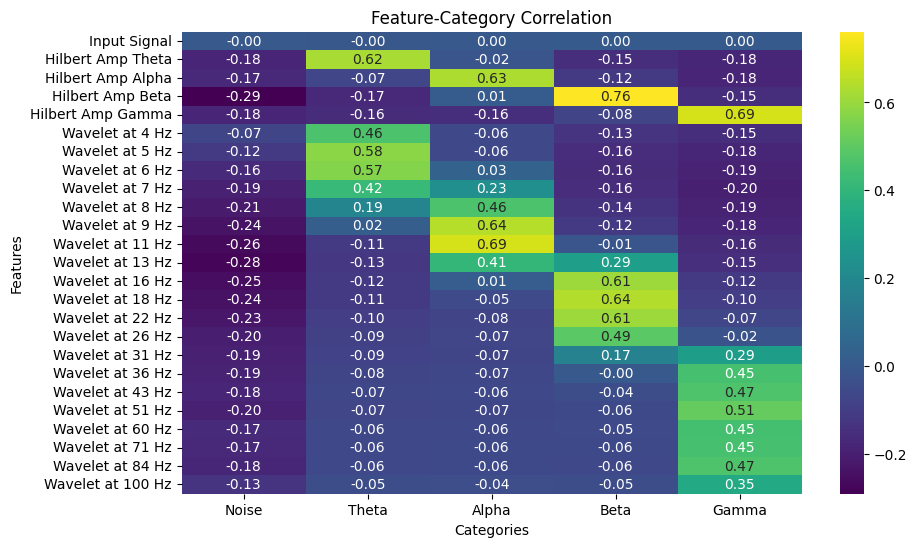

In [ ]:
# Create custom y-axis labels
feature_names = ['Input Signal'] + \
                [f'Hilbert Amp {freq}' for freq in category_names[1:]] + \
                [f'Wavelet at {freq} Hz' for freq in mean_freqs_round]


# Display the correlation table as a heatmap
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.heatmap(correlation_table, annot=True, cmap="viridis", fmt=".2f",
            yticklabels=feature_names)  # Use custom yticklabels
plt.title("Feature-Category Correlation")
plt.xlabel("Categories")
plt.ylabel("Features")
plt.show()

##Complex Plot of Training Data

In [ ]:
#computing spectrum
from neurodsp.spectral import compute_spectrum

signal_vec = data_vec[:,:,:,:,0]

power_list = []
frequencies = []
# Compute Power Spectrum
for snr_idx in range(5):
    noise_idx_signal = signal_vec[:,:,snr_idx].flatten()
    freqs, power = compute_spectrum(noise_idx_signal, fs=250, method='welch', nperseg=256)
    frequencies.append(freqs)
    power_list.append(power)

[ 71  84 100]


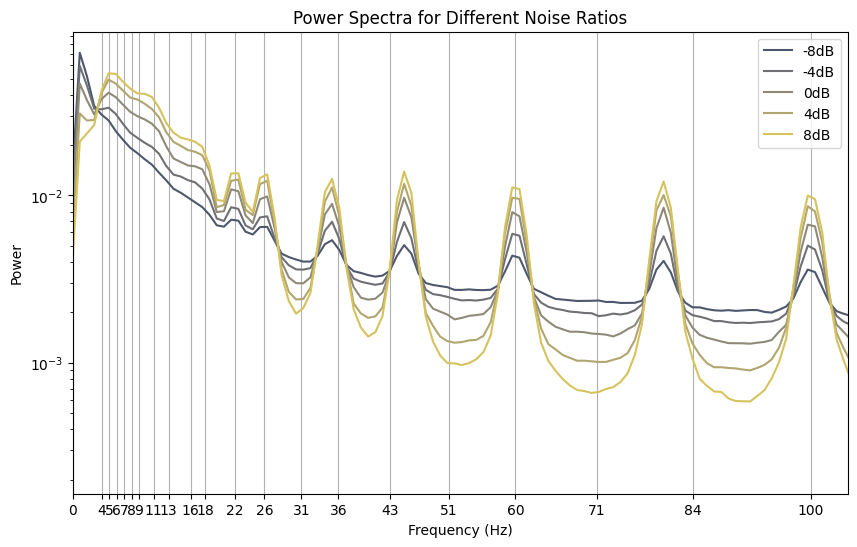

In [ ]:
# Define noise ratio labels
noise_labels = ["-8dB", "-4dB", "0dB", "4dB", "8dB"]

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Plot each power spectrum with a different color from the viridis colormap
colors = plt.cm.cividis(np.linspace(0.3, 0.85, len(power_list)))  # Get colors from YlGnBu_r
for i, power_spectrum in enumerate(power_list):
    plt.semilogy(frequencies[i], power_spectrum, color=colors[i], label=noise_labels[i])

# Customize the plot
plt.title("Power Spectra for Different Noise Ratios")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")

plt.xlim(0,105)
plt.legend()  # Show the legend with noise ratio labels
grid_lines = np.insert(mean_freqs_round, 0, 0)
plt.xticks(grid_lines)  # Set ticks at mean_freqs_round values
plt.grid(True, which='both', axis='x')  # Enable grid lines for x-axis ticks
print((mean_freqs_round[-3:]))
plt.show()

## Signal Visualizations

In [4]:
base_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/"

data_path = f"{base_path}5_class_test_burst_vec.npy"
label_path = f"{base_path}5_class_test_label_vec.npy"

data_vec_small, label_vec_small = du.load_data(data_path, label_path)

# Assuming burst_vec has shape (5, 4, 750)
new_burst_vec_small = data_vec_small.reshape(data_vec_small.shape[0], data_vec_small.shape[1] * data_vec_small.shape[2])
new_label_vec_small = label_vec_small.reshape(label_vec_small.shape[0], label_vec_small.shape[1] * label_vec_small.shape[2])

print(new_burst_vec_small.shape)
print(new_label_vec_small.shape)

(5, 2000)
(5, 2000)


In [5]:
test_data_vec = np.load(f"{base_path}5_class_test_feature_vec.npy")

test_data_vec.shape

(5, 2000, 25)

## Special Dataset Visualizations

In [6]:
# TODO: Modify to also Display the features

def visualize_training_data(label_sample, signal_sample, sampling_frequency=250, duration=60, time_window=(0, 10), category_labels=['noise', 'beta'], title="Ground Truth of When Bursts Occur"):
    """
    Visualizes training data with ground truth labels and signal plot.

    Args:
        label_sample (np.ndarray): 2D array of ground truth labels (n_samples, n_data_points).
        signal_sample (np.ndarray): 2D array of signal data (n_samples, n_data_points).
        sampling_frequency (int, optional): Sampling frequency of the data. Defaults to 250.
        duration (int, optional): Duration of the data in seconds. Defaults to 60.
        time_window (tuple, optional): Time window to display in seconds (start, end). Defaults to (0, 10).
        category_labels (list, optional): Labels for the categories in the stackplot. Defaults to ['noise', 'beta'].
    """

    num_plots = label_sample.shape[0]  # Get the number of plots from the first dimension of label_sample
    time_vec = np.linspace(0, duration, int(duration * sampling_frequency), endpoint=False)

    if num_plots == 3:
        noise_ratios = [-8,0,8]
    else:
        noise_ratios = [-8,-4,0,4,8]

    fig, axes = plt.subplots(num_plots, 1, figsize=(20, 3 * num_plots), sharex=False)

    for i in range(num_plots):
        # Get data for the current plot
        current_label_sample = label_sample[i].flatten()
        current_signal_sample = signal_sample[i].flatten()
        max_value = np.max(current_signal_sample) * 1.05
        min_value = np.min(current_signal_sample) * 1.05

        # One-hot encode labels
        current_label_sample = du.one_hot_encode_single_sample(current_label_sample, categories=np.unique(current_label_sample))

         # Get colors for the stack plots
        colors = plt.cm.get_cmap('Set1', len(category_labels))  # Or any other colormap you prefer
        custom_colors = ['lightblue', 'orange', 'green', 'red', 'purple']
        cc = custom_colors[:current_label_sample.shape[1]]

        axes[i].plot(time_vec, current_signal_sample, color="k", linewidth=1.5)

        # the period of blue: bursts (adjust linewidth here)
        handle = axes[i].stackplot(time_vec, current_label_sample.T * max_value, labels=category_labels, alpha=0.4, linewidth=2, colors=cc)
        axes[i].stackplot(time_vec, current_label_sample.T * min_value, alpha=0.4, linewidth=2, colors=cc)

        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("Amplitude")
        axes[i].set_title(f"Signal Plot ({noise_ratios[i]}dB SNR)", fontsize=15)
        axes[i].set_ylim(min_value, max_value)
        axes[i].set_xlim(time_window[0], time_window[1])

    # Import Line2D for creating custom legend entry
    from matplotlib.lines import Line2D

    # Create custom legend entry for the signal
    signal_line = Line2D([0], [0], color='k', lw=2, label='Signal')

    # Combine legend entries
    handles = [signal_line] + handle  # Add the custom signal line entry to handles
    labels = ['Signal'] + category_labels[:current_label_sample.shape[1]]   # Add label for signal line

    # Place legend below the subplots and arrange horizontally
    plt.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, -0.1),  # Position below the plot
               ncol=len(labels),  # Arrange horizontally
               fancybox=True, shadow=False, fontsize=15)  # Add fancy box and shadow (optional)

    plt.xlim(time_window[0], time_window[1])
    plt.tight_layout()
    plt.show()

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define the color groups
color_groups = {
    'theta': 'YlOrBr',  # Use 'Yellows' for theta
    'alpha': 'Greens',  # Use 'Greens' for alpha
    'beta': 'Reds',    # Use 'Reds' for beta
    'gamma': 'Purples'  # Use 'Purples' for gamma
}

# Create a function to generate a colormap with 5 shades of a given color
def create_colormap(base_color, shade_range=(0.3, 0.9)):  # Added shade_range parameter
    colors = [plt.cm.get_cmap(base_color)(i) for i in np.linspace(shade_range[0], shade_range[1], 5)]
    return LinearSegmentedColormap.from_list(f'{base_color}_cmap', colors)

# Generate the colormaps for each block
theta_cmap = create_colormap(color_groups['theta'], shade_range=(0.25, 0.5))
alpha_cmap = create_colormap(color_groups['alpha'])
beta_cmap = create_colormap(color_groups['beta'], shade_range=(0.65, 1))
gamma_cmap = create_colormap(color_groups['gamma'], shade_range=(0.3, 1))

# Store the colormaps in a dictionary for easy access
block_colormaps = {
    0: theta_cmap,
    1: alpha_cmap,
    2: beta_cmap,
    3: gamma_cmap
}

def visualize_simplified_wavelet_plot_with_labels_v2(label_sample, feature_sample, sampling_frequency=250, duration=8, category_labels=['noise', 'theta', 'alpha', 'beta', 'gamma'], title="Signal and Features with Labels"):
    """
    Visualizes signal, Hilbert amplitudes, and wavelet amplitudes with ground truth labels as stackplots in the background.
    Uses encoded label overlays and extracts signal/amplitudes from the feature array.

    Args:
        label_sample (np.ndarray): 1D array of ground truth labels.
        feature_sample (np.ndarray): 2D array of shape (n_timepoints, 25) where columns are:
                                     [0]=signal, [1:5]=Hilbert amplitudes, [5:]=wavelet amplitudes.
        sampling_frequency (int): Sampling frequency of the signal.
        duration (int): Duration in seconds to visualize.
        category_labels (list): Names of the label categories.
        title (str): Plot title.
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm

    time_vec = np.linspace(0, duration, int(duration * sampling_frequency), endpoint=False)
    n_timepoints = len(time_vec)

    # One-hot encode labels
    label_sample_oh = du.one_hot_encode_single_sample(label_sample[:n_timepoints], categories=np.unique(label_sample))
    custom_colors = ['lightblue', 'orange', 'green', 'red', 'darkblue']
    label_colors = custom_colors[:label_sample_oh.shape[1]]

    # Extract components
    signal = feature_sample[:n_timepoints, 0]
    hilbert_amplitudes = feature_sample[:n_timepoints, 1:5]
    wavelet_amplitudes = feature_sample[:n_timepoints, 5:]
    wavelet_freqs = np.round(np.logspace(np.log10(4), np.log10(100), 20)).astype(int)

    hilbert_labels = ["Theta", "Alpha", "Beta", "Gamma"]

    fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

    # Plot signal
    axs[0].plot(time_vec, signal, color='black', label="Signal")
    axs[0].stackplot(time_vec, (label_sample_oh * signal.max() * 1.1).T, colors=label_colors, alpha=0.3)
    axs[0].stackplot(time_vec, (label_sample_oh * signal.min() * 1.1).T, colors=label_colors, alpha=0.3)
    axs[0].set_ylabel("Amplitude")
    axs[0].set_title("Raw Signal")

    # Plot Hilbert amplitudes
    for i in range(4):
        axs[1].plot(time_vec, hilbert_amplitudes[:, i], label=hilbert_labels[i], alpha=0.7, color=label_colors[i+1])
    #axs[1].stackplot(time_vec, (label_sample_oh * hilbert_amplitudes.max() * 1.1 ).T, colors=label_colors, alpha=0.3)
    axs[1].legend()
    axs[1].set_ylabel("Hilbert Amp")
    axs[1].set_title("Hilbert Band Amplitudes")

    # Plot grouped wavelets (5 per 2s)
# Plot grouped wavelets (5 per 2s)
    block_duration = 2  # seconds
    block_samples = block_duration * sampling_frequency
    freq_band_indices = [(0, 4), (4, 7), (7, 12), (12, 20)]  # Define frequency band indices
    for block, (start_idx, end_idx) in enumerate(freq_band_indices):
        start = block * block_samples  # Shifted start by -2 seconds
        end = (block + 1) * block_samples
        cmap = block_colormaps[block]  # Get the colormap for the current block
        colors = [cmap(i) for i in np.linspace(0, 1, end_idx-start_idx)]  # Get 5 colors from the colormap

        for i in range(end_idx-start_idx): #for i in range(5)
            idx = start_idx + i # block * 5 + i
            if idx < wavelet_amplitudes.shape[1]:
                if idx in [4, 7, 12]:
                    axs[2].plot(time_vec[start-500:end], wavelet_amplitudes[start-500:end, idx], label=f'{wavelet_freqs[idx]} Hz', color=colors[i], linewidth=2)
                if idx in [3, 11]:
                    axs[2].plot(time_vec[start:end+500], wavelet_amplitudes[start:end+500, idx], label=f'{wavelet_freqs[idx]} Hz', color=colors[i], linewidth=2)
                else:
                    axs[2].plot(time_vec[start:end], wavelet_amplitudes[start:end, idx], label=f'{wavelet_freqs[idx]} Hz', color=colors[i])
    axs[2].stackplot(time_vec, (label_sample_oh * wavelet_amplitudes.max() * 1.1).T, colors=label_colors, alpha=0.0)
    axs[2].legend(ncol=4, fontsize=8, loc="upper left")
    axs[2].set_ylabel("Wavelet Amp")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_title("Wavelet Amplitudes (5 per 2-second block)")


    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.xlim(0, duration)
    plt.show()


<ipython-input-72-2240817e6185>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap(base_color)(i) for i in np.linspace(shade_range[0], shade_range[1], 5)]


In [20]:
new_label_vec_small.shape

(5, 2000)

In [32]:
mean_freqs = np.logspace(np.log10(4), np.log10(100), num=20)
mean_freqs_round = np.round(mean_freqs).astype(int)

In [59]:
mean_freqs_round[4]

np.int64(8)

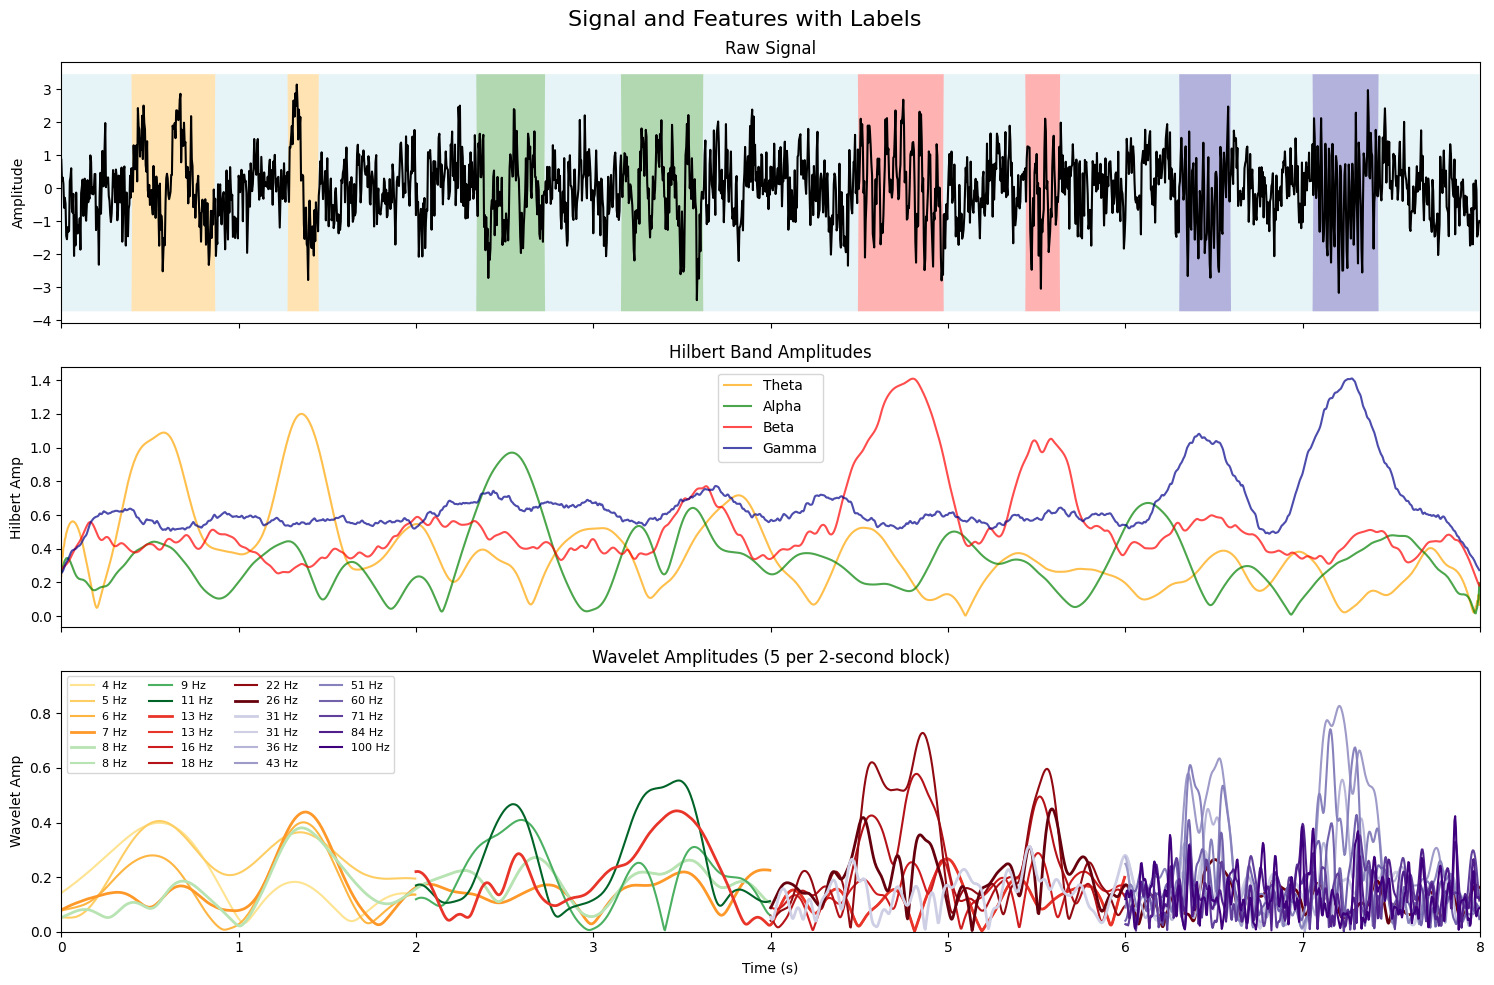

In [76]:
category_labels = ["Noise", "Theta", "Alpha", "Beta", "Gamma"]
noise_level = 1

visualize_simplified_wavelet_plot_with_labels_v2(new_label_vec_small[noise_level], test_data_vec[noise_level], duration=8)

## FREQS PRESENT:
## 4 Hz, 11Hz, 20Hz, 45Hz

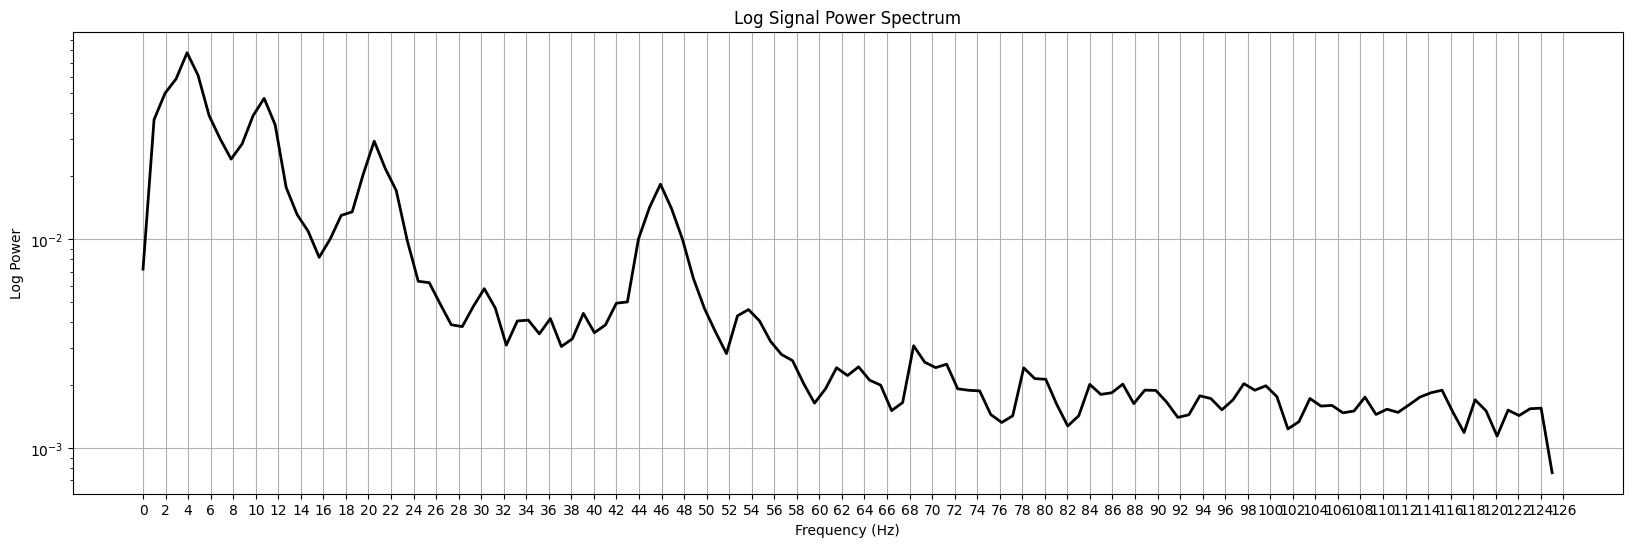

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from neurodsp.spectral import compute_spectrum

def plot_log_signal_power(signal_data, sampling_frequency=250):
    """
    Creates a log signal power plot from a single array of timesteps.

    Args:
        signal_data (np.ndarray): 1D array of signal data.
        sampling_frequency (int, optional): Sampling frequency of the data. Defaults to 250.
    """

    # Compute the power spectrum using Welch's method
    freqs, power = compute_spectrum(signal_data, fs=sampling_frequency, method='welch', nperseg=256)

    # Create the plot with a logarithmic y-axis
    plt.figure(figsize=(20, 6))
    plt.semilogy(freqs, power, color='black', linewidth=2)  # Use semilogy for log y-axis
    plt.title("Log Signal Power Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Log Power")

    # Add more x-ticks for better frequency localization (every 2 Hz)
    plt.xticks(np.arange(0, freqs[-1] + 2, 2))

    plt.grid(True)
    plt.show()

# Example usage:
# Assuming you have your signal data in a variable called 'signal_data'
# plot_log_signal_power(signal_data)

# Example usage:
# Assuming you have your signal data in a variable called 'signal_data'
plot_log_signal_power(test_data_vec[:, : , 0].flatten())

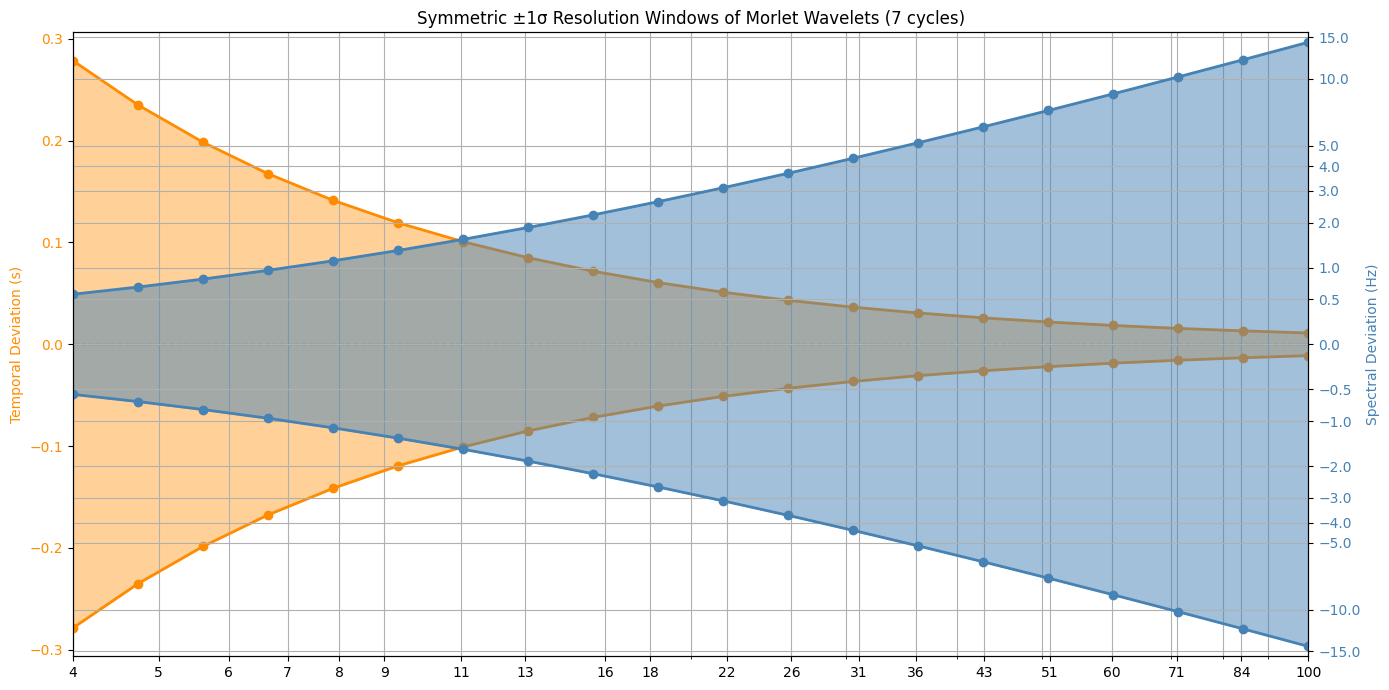

In [ ]:
mean_freqs = np.logspace(np.log10(4), np.log10(100), num=20)
mean_freqs_round = np.round(mean_freqs).astype(int)

n_cycles = 7

def symlog(x):
    """
    Applies a symmetric log scale to the input data.
    """
    return np.sign(x) * np.log1p(np.abs(x))

# Reconstruct the dataframe with numeric columns
rounded_frequencies = mean_freqs
temporal_window_1std = n_cycles / (2 * np.pi * rounded_frequencies)
temporal_window_3std = 3 * temporal_window_1std
spectral_window_1std = rounded_frequencies / n_cycles
spectral_window_3std = 3 * spectral_window_1std

df_windows_numeric = pd.DataFrame({
    "Center Frequency (Hz)": rounded_frequencies,
    "Temporal Window 1σ (s)": temporal_window_1std,
    "Temporal Window 3σ (s)": temporal_window_3std,
    "Spectral Window 1σ (Hz)": spectral_window_1std,
    "Spectral Window 3σ (Hz)": spectral_window_3std
})



# Create the plot with enhanced features: x-ticks and dot markers
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.fill_between(rounded_frequencies, -temporal_window_1std, temporal_window_1std, color='darkorange', alpha=0.4, label='Temporal ±1σ')
ax1.plot(rounded_frequencies, temporal_window_1std, color='darkorange', linewidth=2, marker='o')
ax1.plot(rounded_frequencies, -temporal_window_1std, color='darkorange', linewidth=2, marker='o')

ax1.set_ylabel('Temporal Deviation (s)', color='darkorange')
ax1.tick_params(axis='y', labelcolor='darkorange')
ax1.set_ylim(-max(temporal_window_1std)*1.1, max(temporal_window_1std)*1.1)
ax1.grid(True, which='both', axis='x')  # Enable grid for both x and y

ax2 = ax1.twinx()
# Plot spectral resolution (frequency domain) with shaded areas and dots
ax2.fill_between(rounded_frequencies, -spectral_window_1std, spectral_window_1std, color='steelblue', alpha=0.5, label='Spectral ±1σ')
ax2.plot(rounded_frequencies, spectral_window_1std, color='steelblue', linewidth=2, marker='o')
ax2.plot(rounded_frequencies, -spectral_window_1std, color='steelblue', linewidth=2, marker='o')

ax2.set_xscale('log')  # This line is added
ax2.set_xlabel("Center Frequency (Hz)")
ax2.set_xticks(mean_freqs_round)
ax2.set_xticklabels(mean_freqs_round)

ax2.set_yscale('function', functions=(symlog, np.expm1))
ax2.set_ylabel('Spectral Deviation (Hz)', color='steelblue')
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2.set_yticks([-15,-10, -5, -4, -3, -2, -1, -0.5, 0, 0.5, 1,2,3,4,5, 10,15])
ax2.set_ylim(-max(spectral_window_1std)*1.1, max(spectral_window_1std)*1.1)
ax2.grid(True, which='both', axis='both')  # Enable grid for both x and y


# Draw horizontal line at y=0
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)

# Title and layout
plt.title("Symmetric ±1σ Resolution Windows of Morlet Wavelets (7 cycles)")
fig.tight_layout()
plt.xlim(4,100)
plt.show()


## Feature Visualization with Signal

In [ ]:
# Define noise ratio labels
noise_labels = ["-8dB", "-4dB", "0dB", "4dB", "8dB"]

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

power_spectrum_data = {'frequencies': [], 'power': []}
# Plot each power spectrum with a different color from the viridis colormap
colors = plt.cm.cividis(np.linspace(0.3, 0.85, len(power_list)))  # Get colors from YlGnBu_r
for i in [0,2,4]:
    plt.semilogy(frequencies[i], power_list[i], color=colors[i], label=noise_labels[i])
    power_spectrum_data['frequencies'].append(frequencies[i])
    power_spectrum_data['power'].append(power_list[i])

# Customize the plot
plt.title("Power Spectra for Different Noise Ratios")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")

plt.xlim(0,105)
plt.legend()  # Show the legend with noise ratio labels
grid_lines = np.insert(mean_freqs_round, 0, 0)
plt.xticks(grid_lines)  # Set ticks at mean_freqs_round values
plt.grid(True, which='both', axis='x')  # Enable grid lines for x-axis ticks
plt.show()

NameError: name 'power_list' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def visualize_all_data(label_sample, signal_sample, feature_sample, power_spectrum_data, sampling_frequency=250, duration=60, time_window=(0, 10), category_labels=['noise', 'beta'], title="Ground Truth of When Bursts Occur"):
    """
    Visualizes signal data with features and ground truth labels in a 2x2 grid layout.

    Args:
        label_sample (np.ndarray): 2D array of ground truth labels (n_samples, n_data_points).
        signal_sample (np.ndarray): 2D array of signal data (n_samples, n_data_points).
        feature_sample (np.ndarray): 3D array of feature data (n_samples, n_data_points, n_features).
        power_spectrum_data (dict): Dictionary containing 'frequencies' and 'power' for the power spectrum.
        sampling_frequency (int, optional): Sampling frequency of the data. Defaults to 250.
        duration (int, optional): Duration of the data in seconds. Defaults to 60.
        time_window (tuple, optional): Time window to display in seconds (start, end). Defaults to (0, 10).
        category_labels (list, optional): Labels for the categories in the stackplot. Defaults to ['noise', 'beta'].
        title (str, optional): Title of the plot. Defaults to "Ground Truth of When Bursts Occur".
    """

    num_plots = label_sample.shape[0]
    time_vec = np.linspace(0, duration, int(duration * sampling_frequency), endpoint=False)
    num_features = feature_sample.shape[-1]
    print(num_features)

    if num_plots == 3:
        noise_ratios = [-8, 0, 8]
    else:
        noise_ratios = [-8, -4, 0, 4, 8]

     # Create subplots in a 2x2 grid for each noise ratio with adjusted widths
    fig, axes = plt.subplots(2 * num_plots, 2, figsize=(25, 6 * num_plots), sharex=False,
                            gridspec_kw={'width_ratios': [4, 1]})  # Adjust width_ratios

    for i in range(num_plots):
        current_label_sample = label_sample[i].flatten()
        current_signal_sample = signal_sample[i].flatten()
        current_feature_sample = feature_sample[i]
        max_value = np.max(current_signal_sample) * 1.05
        min_value = np.min(current_signal_sample) * 1.05

        # One-hot encode labels
        current_label_sample = du.one_hot_encode_single_sample(current_label_sample, categories=np.unique(current_label_sample))

        # Get colors for the stack plots
        colors = plt.cm.get_cmap('Set1', len(category_labels))
        custom_colors = ['lightblue', 'orange', 'green', 'red', 'darkblue']
        cc = custom_colors[:current_label_sample.shape[1]]

        # Plot Signal in the top left (axes[2*i, 0])
        axes[2*i, 0].plot(time_vec, current_signal_sample, color="k", linewidth=1.5)
        handle = axes[2*i, 0].stackplot(time_vec, current_label_sample.T * max_value, labels=category_labels, alpha=0.4, linewidth=2, colors=cc)
        axes[2*i, 0].stackplot(time_vec, current_label_sample.T * min_value, alpha=0.4, linewidth=2, colors=cc)
        axes[2*i, 0].set_xlabel("Time (s)")
        axes[2*i, 0].set_ylabel("Amplitude")
        # axes[2*i, 0].set_title(f"Signal Plot ({noise_ratios[i]}dB SNR)", fontsize=15)
        axes[2*i, 0].set_ylim(min_value, max_value)
        axes[2*i, 0].set_xlim(time_window[0], time_window[1])
        axes[2*i, 0].tick_params(axis='both', which='major', labelsize=12)  # Adjust labelsize as needed


        # Plot Power Spectrum in the top right (axes[2*i, 1])
        axes[2*i, 1].semilogy(power_spectrum_data['frequencies'][i], power_spectrum_data['power'][i], color='black', linewidth=2)
        axes[2*i, 1].set_xlim(0,110)
        axes[2*i, 1].set_yscale("log")
        axes[2*i, 1].set_xlabel("Frequency (Hz)")
        axes[2*i, 1].set_ylabel("Log Power")
        axes[2*i, 1].tick_params(axis='both', which='major', labelsize=12)  # Adjust labelsize as needed


        # Plot Hilbert Transform in the bottom left (axes[2*i+1, 0])
        for feature_idx in range(4):  # Assuming 4 Hilbert features
            labels = ["Theta Amp", "Alpha Amp", "Beta Amp", "Gamma Amp"]
            axes[2*i+1, 0].plot(time_vec, current_feature_sample[:, feature_idx], color=cc[feature_idx + 1], alpha=0.6, label=labels[feature_idx], linewidth=2)
            # axes[2*i+1, 0].legend()
            axes[2*i+1, 0].set_xlabel("Time (s)")
            axes[2*i+1, 0].set_xlim(time_window)

        # Plot Wavelet Transform in the bottom right (axes[2*i+1, 1])
        if num_features > 4:
            mean_freqs = np.logspace(np.log10(4), np.log10(100), num=20)
            mean_freqs_round = np.round(mean_freqs).astype(int)
            time_mesh, freq_mesh = np.meshgrid(time_vec, mean_freqs_round[:num_features - 4])
            im = axes[2*i+1, 1].imshow(current_feature_sample[:, 4:].T, aspect='auto', origin='lower',
                                      extent=[time_vec[0], time_vec[-1], mean_freqs_round[0], mean_freqs_round[num_features - 5]],
                                      cmap='viridis')
            axes[2*i+1, 1].set_aspect(0.05)
            #axes[2*i+1, 1].set_xlabel("Time (s)")
            axes[2*i+1, 1].set_ylabel("Frequency (Hz)")
            cbar = fig.colorbar(im, ax=axes[2*i+1, 1])
            cbar.set_label("Power")

    # Legend
    signal_line = Line2D([0], [0], color='k', lw=2, label='Signal')
    handles = [signal_line] + list(handle)
    labels = ['Signal'] + category_labels[:current_label_sample.shape[1]]
    fig.legend(handles=handles, labels=labels, loc='lower center',
               bbox_to_anchor=(0.4, -0.05),  # Adjust anchor for position
               ncol=len(labels), fancybox=True, shadow=False, fontsize=15)

    plt.xlim(time_window[0], time_window[1])

    plt.tight_layout(pad=1)

    plt.subplots_adjust(hspace=0.2, wspace=0.16)  # Adjust values as needed
    plt.show()

In [ ]:
category_labels=['noise', 'theta', 'alpha', 'beta', 'gamma']

new_test_data_vec = np.delete(test_data_vec, [1, 3], axis=0)
new_label_vec = np.delete(new_label_vec_small, [1, 3], axis=0)

signal_sample = new_test_data_vec[:,:,0]
hilbert_sample = new_test_data_vec[:,:,1:]

label_sample = new_label_vec[:,:]

print(signal_sample.shape)
print(hilbert_sample.shape)
print(label_sample.shape)
# Freqs used: [5,11,22,50]

visualize_all_data(label_sample, signal_sample, hilbert_sample, power_spectrum_data, duration=8, time_window=(0, 8),
                       category_labels=category_labels)

(3, 2000)
(3, 2000, 24)
(3, 2000)


NameError: name 'power_spectrum_data' is not defined

<ipython-input-55-02de5eedec8a>:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', len(category_labels))  # Or any other colormap you prefer


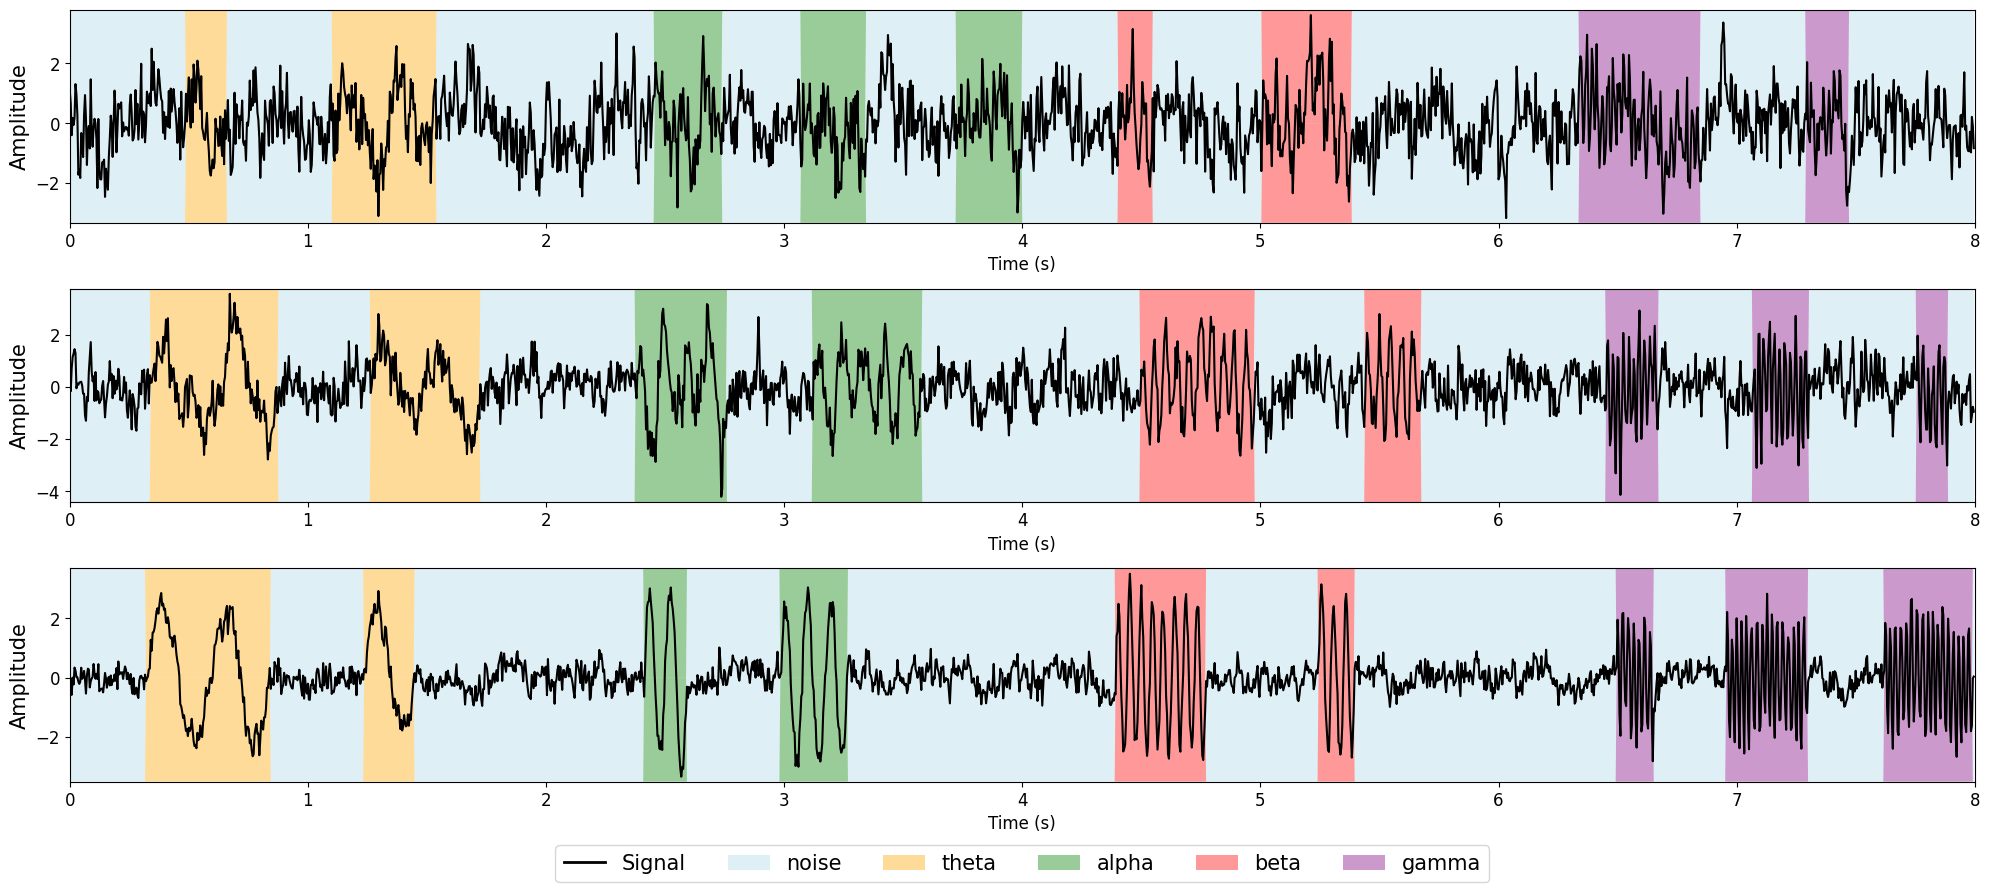

In [ ]:
visualize_signal_data(label_sample, signal_sample, duration=8, time_window=(0, 8),
                       category_labels=category_labels)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def visualize_signal_data(label_sample, signal_sample, sampling_frequency=250, duration=60, time_window=(0, 10), category_labels=['noise', 'beta'], title="Ground Truth of When Bursts Occur"):
    """
    Visualizes signal data with ground truth labels.

    Args:
        label_sample (np.ndarray): 2D array of ground truth labels (n_samples, n_data_points).
        signal_sample (np.ndarray): 2D array of signal data (n_samples, n_data_points).
        sampling_frequency (int, optional): Sampling frequency of the data. Defaults to 250.
        duration (int, optional): Duration of the data in seconds. Defaults to 60.
        time_window (tuple, optional): Time window to display in seconds (start, end). Defaults to (0, 10).
        category_labels (list, optional): Labels for the categories in the stackplot. Defaults to ['noise', 'beta'].
        title (str, optional): Title of the plot. Defaults to "Ground Truth of When Bursts Occur".
    """

    num_plots = label_sample.shape[0]  # Get the number of plots from the first dimension of label_sample
    time_vec = np.linspace(0, duration, int(duration * sampling_frequency), endpoint=False)

    if num_plots == 3:
        noise_ratios = [-8, 0, 8]
    else:
        noise_ratios = [-8, -4, 0, 4, 8]

    fig, axes = plt.subplots(num_plots, 1, figsize=(20, 3 * num_plots), sharex=False)

    for i in range(num_plots):
        # Get data for the current plot
        current_label_sample = label_sample[i].flatten()
        current_signal_sample = signal_sample[i].flatten()
        max_value = np.max(current_signal_sample) * 1.05
        min_value = np.min(current_signal_sample) * 1.05

        # One-hot encode labels
        current_label_sample = du.one_hot_encode_single_sample(current_label_sample, categories=np.unique(current_label_sample))

        # Get colors for the stack plots
        colors = plt.cm.get_cmap('Set1', len(category_labels))  # Or any other colormap you prefer
        custom_colors = ['lightblue', 'orange', 'green', 'red', 'purple']
        cc = custom_colors[:current_label_sample.shape[1]]

        axes[i].plot(time_vec, current_signal_sample, color="k", linewidth=1.5)

        # the period of blue: bursts (adjust linewidth here)
        handle = axes[i].stackplot(time_vec, current_label_sample.T * max_value, labels=category_labels, alpha=0.4, linewidth=2, colors=cc)
        axes[i].stackplot(time_vec, current_label_sample.T * min_value, alpha=0.4, linewidth=2, colors=cc)

        axes[i].set_xlabel("Time (s)", fontsize=12)
        axes[i].set_ylabel("Amplitude", fontsize=15)
        axes[i].set_ylim(min_value, max_value)
        axes[i].set_xlim(time_window[0], time_window[1])
        axes[i].tick_params(axis='both', which='major', labelsize=12)  # Adjust labelsize as needed


    # Import Line2D for creating custom legend entry
    from matplotlib.lines import Line2D

    # Create custom legend entry for the signal
    signal_line = Line2D([0], [0], color='k', lw=2, label='Signal')

    # Combine legend entries
    handles = [signal_line] + handle  # Add the custom signal line entry to handles
    labels = ['Signal'] + category_labels[:current_label_sample.shape[1]]   # Add label for signal line

    # Place legend below the subplots and arrange horizontally
    plt.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, -0.25),  # Position below the plot
               ncol=len(labels),  # Arrange horizontally
               fancybox=True, shadow=False, fontsize=15)  # Add fancy box and shadow (optional)

    plt.xlim(time_window[0], time_window[1])
    plt.tight_layout()
    plt.show()

In [ ]:
  # Import Line2D outside the loop

def visualize_feature_data(label_sample, signal_sample, feature_sample, sampling_frequency=250, duration=60, time_window=(0, 10), category_labels=['noise', 'beta'], title="Ground Truth of When Bursts Occur"):
    """
    Visualizes training data with ground truth labels and signal plot.

    Args:
        label_sample (np.ndarray): 2D array of ground truth labels (n_samples, n_data_points).
        signal_sample (np.ndarray): 2D array of signal data (n_samples, n_data_points).
        sampling_frequency (int, optional): Sampling frequency of the data. Defaults to 250.
        duration (int, optional): Duration of the data in seconds. Defaults to 60.
        time_window (tuple, optional): Time window to display in seconds (start, end). Defaults to (0, 10).
        category_labels (list, optional): Labels for the categories in the stackplot. Defaults to ['noise', 'beta'].
    """
    from matplotlib.lines import Line2D
    num_plots = label_sample.shape[0]  # Get the number of plots from the first dimension of label_sample
    time_vec = np.linspace(0, duration, int(duration * sampling_frequency), endpoint=False)
    num_features = feature_sample.shape[-1]
    print(num_features)

    if num_plots == 3:
        noise_ratios = [-8,0,8]
    else:
        noise_ratios = [-8,-4,0,4,8]

    fig, axes = plt.subplots(2* num_plots, 1, figsize=(20, 6 * num_plots), sharex=False)
    wavelet_labels = []
    wavelet_handles = []
    for i in range(num_plots):
        print(i)
        # Get data for the current plot
        current_label_sample = label_sample[i].flatten()
        current_signal_sample = signal_sample[i].flatten()
        current_feature_sample = feature_sample[i]
        max_value = np.max(current_signal_sample) * 1.05
        min_value = np.min(current_signal_sample) * 1.05

        # One-hot encode labels
        current_label_sample = du.one_hot_encode_single_sample(current_label_sample, categories=np.unique(current_label_sample))

         # Get colors for the stack plots
        custom_colors = ['lightblue', 'orange', 'green', 'red', 'purple']
        cc = custom_colors[:current_label_sample.shape[1]]

        axes[2*i].plot(time_vec, current_signal_sample, color="k", linewidth=1.5)

        # the period of blue: bursts (adjust linewidth here)
        handle = axes[2*i].stackplot(time_vec, current_label_sample.T * max_value, labels=category_labels, alpha=0.4, linewidth=2, colors=cc)
        axes[2*i].stackplot(time_vec, current_label_sample.T * min_value, alpha=0.4, linewidth=2, colors=cc)

        axes[2*i].set_xlabel("Time (s)")
        axes[2*i].set_ylabel("Amplitude")
        axes[2*i].set_title(f"Signal Plot ({noise_ratios[i]}dB SNR)", fontsize=15)
        axes[2*i].set_ylim(min_value, max_value)
        axes[2*i].set_xlim(time_window[0], time_window[1])


        for feature_idx in range(num_features):
          if num_features == 4:
              labels = ["Theta Amp", "Alpha Amp", "Beta Amp", "Theta Amp"]
              axes[2*i+1].plot(time_vec, current_feature_sample[:,feature_idx], color=cc[feature_idx+1], alpha=0.6, label=labels[feature_idx], linewidth=2)
              axes[2*i+1].set_title(f"Hilbert Amplitude")
          else:
              mean_freqs = np.logspace(np.log10(4), np.log10(100), num=20)
              mean_freqs_round = np.round(mean_freqs).astype(int)
              label = f'Wavelets at Freq: {mean_freqs_round[feature_idx]} Hz'
              color = plt.cm.gist_rainbow(np.linspace(0.1, 0.95, num_features))
              custom_colors = custom_cmap(np.linspace(0, 1, 20))
              colors = custom_colors[:num_features]
              # Store and plot only for the first sample to avoid redundancy
              if i == 1:
                    wavelet_labels.append(label)
                    axes[2*i+1].plot(time_vec, current_feature_sample[:,feature_idx], color=colors[feature_idx], label=label, alpha=0.7)
                    # Create unique color for handle

                    wavelet_handles.append(Line2D([0], [0], color=colors[feature_idx], lw=2, alpha=0.7))
              else:
                    axes[2*i+1].plot(time_vec, current_feature_sample[:,feature_idx], color=colors[feature_idx], alpha=0.7)
              axes[2*i+1].set_title(f"All Wavelets")
        # Overall maximum
        max_value = np.max(current_feature_sample)
        #axes[2*i+1].stackplot(time_vec, label_sample[i]*max_value, labels=["Ground Truth"], alpha=0.7, colors=['lightblue'])
        axes[2*i+1].set_xlabel("Time (s)")
        axes[2*i+1].legend()
        axes[2*i+1].set_xlim(time_window)
        axes[2*i+1].set_ylim(0, max_value)

        if i == 1:
            axes[2 * i + 1].legend(handles=wavelet_handles, labels=wavelet_labels,
                                 loc='center left', bbox_to_anchor=(1.05, 0.5),  # Position to the right
                                 fontsize=12)

    # Create custom legend entry for the signal
    signal_line = Line2D([0], [0], color='k', lw=2, label='Signal')

    print(wavelet_labels)
    # Combine legend entries
    handles = [signal_line] + handle  # Add the custom signal line entry to handles
    labels = ['Signal'] + category_labels[:current_label_sample.shape[1]]   # Add label for signal line

    # Place legend below the subplots and arrange horizontally
    plt.legend(handles=handles, labels=labels,
               loc='upper center', bbox_to_anchor=(0.5, -0.2),  # Position below the plot
               ncol=len(labels),  # Arrange horizontally
               fancybox=True, shadow=False, fontsize=15)  # Add fancy box and shadow (optional)

    plt.xlim(time_window[0], time_window[1])
    plt.tight_layout(pad=-10)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Define your desired colors
colors = ['orange', 'green', 'red', 'purple']


# Adjust color positions to shift purple earlier
color_positions_normalized = [0, 0.25, 0.5, 1]  # Purple will now reach full intensity at 0.75



# Create a custom colormap using LinearSegmentedColormap
cdict = {'red': [], 'green': [], 'blue': []}
for pos, color in zip(color_positions_normalized, colors):  # Use normalized positions
    r, g, b, _ = plt.cm.colors.to_rgba(color)  # Get RGBA values directly from color name
    cdict['red'].append((pos, r, r))  # Interpolate red
    cdict['green'].append((pos, g, g))  # Interpolate green
    cdict['blue'].append((pos, b, b))  # Interpolate blue


custom_cmap = LinearSegmentedColormap('custom_cmap', cdict)



# Now you can use custom_cmap with 20 values
# Example:
custom_colors = custom_cmap(np.linspace(0, 1, 20))

I have been experimenting with different smooothin settings for the amplitude envelopes seen above.

The higher the frequencies the more smoothing was necessary.

The choice of a butter band-pass filter is one specific one in itself.

I will play with the butter band pass **order** that way I may get more granular results. Especially with a lower order.

What I did:
- Butter Band-Pass Filter
- Increasing values per freq band:
  - Order for band-pass
  - smoothing factor